# Phase Picking CNN Algorithm

#### Paige Given and Albert Leonardo Aguilar Suarez - CS230

### Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import glob
from obspy.core import read
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.stats

In [2]:
from sklearn.model_selection import train_test_split

### Load Data

In [3]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2):
    y_label = np.zeros((30000))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y

def plot_example(x,y):
    plt.figure(figsize=(15,6))    
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right')
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('/Users/paigegiven/Desktop/CSProject/batch2/data*pkl')[:m]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,5,30000))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:]   = x
        Y[i,:,:]   = y
    return X,Y

In [5]:
#X,Y = load_multiple(9663)
X,Y = load_multiple(1000)
print(X.shape,Y.shape)

/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(1000, 3, 30000) (1000, 5, 30000)


#### Visualization of Data

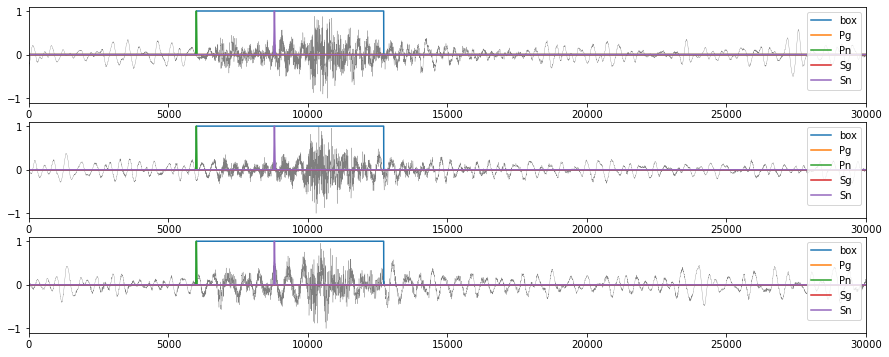

In [6]:
plot_example(X[100],Y[100])

#### Focus on One Seismic Arrival 

In [7]:
Y = Y[:,2,:]  # this gives the Pn label 
# access the labels in this order:
# 0 -> box
# 1 -> pg
# 2 -> pn
# 3 -> sg
# 4 -> sn

In [8]:
Y.shape

(1000, 30000)

#### Divide into Training and Testing Data

In [9]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.10, random_state=42)

In [10]:
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_train shape = ", Y_train.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (900, 3, 30000)
X_test shape =  (100, 3, 30000)
Y_train shape =  (900, 30000)
Y_test shape =  (100, 30000)


## CNN Model

### Model Set-Up

In [11]:
#Create model framework
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 100, minibatch_size = 32, print_cost = True):
    return tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=((3,30000))),  
        keras.layers.Conv1D(32,1,2, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Conv1D(15,1,2, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True),
        keras.layers.Dropout(0.8),
        keras.layers.Conv1D(5,1,2, padding='same', activation='relu'),
        keras.layers.UpSampling1D(size=2),
        keras.layers.UpSampling1D(size=3000),
        keras.layers.Flatten()
    ])

In [12]:
#Assign model with train & test variables and hyperparameters
model = model(X_train, Y_train, X_test, Y_test,learning_rate=0.001, num_epochs = 100, minibatch_size = 32, print_cost = True)

In [13]:
#visualize the model 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 32)             960032    
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 32)             128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 15)             495       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 15)             60        
_________________________________________________________________
dropout (Dropout)            (None, 1, 15)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 5)              8

### Run Model on Training Data to get Predictions

In [14]:
predictions = model(X_train).numpy()
print(predictions[1].shape)
print(predictions[1])

(30000,)
[ 0.02548648  0.00095861  0.02889887 ...,  0.02889887  0.
  0.00037235]


### CTC Loss Function 

In [15]:
loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE,name='categorical_crossentropy')

In [16]:
#loss = tf.nn.ctc_loss(Y_train, predictions,Y_train.shape,predictions.shape)

In [17]:
loss(Y_train, predictions).numpy()

array([   0.     ,    0.     ,  272.08362,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,  250.48419,    0.     ,    0.     ,    0.     ,
          0.     ,  253.67168,    0.     ,    0.     ,  308.477  ,
          0.     ,    0.     ,    0.     ,  247.96367,  250.06915,
          0.     ,  298.98303,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,  349.99286,
          0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,  250.23044,    0.     ,    0.     ,    0.     ,
        321.29837,    0.     ,    0.     ,    0.     ,    0.     ,
        254.84593,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,  271.7213 ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,  249.34853,    0.     ,
          0.     ,    0.     ,  296.526  ,    0.     ,  247.69

### Compile and Run Model

In [22]:
model.compile(optimizer='sgd',loss=loss,metrics=['mse',tf.keras.metrics.RootMeanSquaredError(),'mape','accuracy'])

In [23]:
history=model.fit(X_train, Y_train,epochs=5,shuffle=True)
#plt.plot(history.history['loss'])

Epoch 1/5
29/29 [==============================] - 116s 30ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7233
Epoch 2/5
29/29 [==============================] - 1s 25ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7378
Epoch 3/5
29/29 [==============================] - 1s 25ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7378
Epoch 4/5
29/29 [==============================] - 1s 25ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7378
Epoch 5/5
29/29 [==============================] - 1s 25ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7378


### Evaluate Model

##### Training Score

In [24]:
model.evaluate(X_train, Y_train, verbose=1)

29/29 [==============================] - 1s 12ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7378


[nan, nan, nan, nan, 0.7377777695655823]

##### Testing Score

In [25]:
model.evaluate(X_test, Y_test, verbose=1)

4/4 [==============================] - 0s 8ms/step - loss: nan - mse: nan - root_mean_squared_error: nan - mape: nan - accuracy: 0.7200


[nan, nan, nan, nan, 0.7200000286102295]

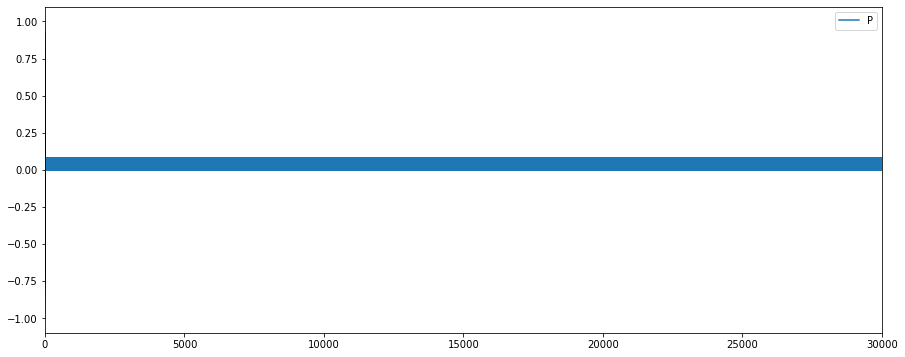

In [28]:
plt.figure(figsize=(15,6)) 
#plt.subplot(3,1,i+1)
plt.plot(X_train[100],c='k',linewidth=0.3,alpha=0.5)
plt.plot(predictions[100],label='P')
#plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
plt.xlim(0,30000)
plt.legend(loc='upper right')

In [29]:
np.max(predictions[100])

0.080634683